In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import time

In [15]:
merged_data = pd.read_csv('https://github.com/edeliciouso/Predicting-Yields-for-Potatoes/blob/main/MergedDataFinal4.csv?raw=true')
merged_data = merged_data.drop(['Item', 'Year'], axis = 1)
merged_data

,Country,Yield (100 hg/ha),Pesticides (Tons),Rainfall (mm),Fertilizer (kg/ha)
0,Albania,55693,410.55,1485.0,79.08
1,Albania,66790,590.50,1485.0,76.47
2,Albania,59869,582.68,1485.0,87.08
3,Albania,67290,361.62,1485.0,82.79
4,Albania,69533,450.60,1485.0,78.15
...,...,...,...,...,...
1194,Zimbabwe,5803,2185.07,657.0,19.17
1195,Zimbabwe,4405,2185.07,657.0,31.78
1196,Zimbabwe,13933,2185.07,657.0,35.71
1197,Zimbabwe,13506,2185.07,657.0,32.39


In [16]:
features = ['Pesticides (Tons)', 'Rainfall (mm)', 'Fertilizer (kg/ha)']
target = 'Yield (100 hg/ha)'

X = merged_data[features]
y = merged_data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [17]:
# Create a pipeline with StandardScaler and DecisionTreeRegressor
pipeline_dt = Pipeline([
    ('scaler', StandardScaler()),
    ('dt', DecisionTreeRegressor())
])

# Search for the optimal hyperparameters for Decision Tree using GridSearch
param_grid_dt = {
    'dt__max_depth': [None, 10, 20, 30],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
    'dt__max_features': [1.0, 'sqrt', 'log2']
}

search_dt = GridSearchCV(pipeline_dt, param_grid=param_grid_dt, cv=5).fit(X_train, y_train)

print("The best hyperparameters for Decision Tree are ", search_dt.best_params_)

The best hyperparameters for Decision Tree are  {'dt__max_depth': 20, 'dt__max_features': 1.0, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 2}


In [34]:
# Get the best estimator from the grid search
best_estimator_dt = search_dt.best_estimator_

# Training the DecisionTreeRegressor model
start_training_time_dt = time.time()
best_estimator_dt.fit(X_train, y_train)
end_training_time_dt = time.time()
training_time_dt = end_training_time_dt - start_training_time_dt

# Make predictions
start_prediction_time_dt = time.time()
y_pred = best_estimator_dt.predict(X_test)
end_prediction_time_dt = time.time()
prediction_time_dt = end_prediction_time_dt - start_prediction_time_dt

In [28]:
# Evaluate the model
r2_dt = r2_score(y_test, y_pred)  # R^2
mae_dt = mean_absolute_error(y_test, y_pred)  # mean absolute error
mse_dt = mean_squared_error(y_test, y_pred)  # mean squared error
rmse_dt = mean_squared_error(y_test, y_pred, squared=False)  # root mean squared error
max_err_dt = max_error(y_test, y_pred)  # max error
mape_dt = mean_absolute_percentage_error(y_test, y_pred)  # mean absolute percentage error

print(f"Decision Tree Regression Metrics:")
print(f"R-squared (R2): {r2_dt:.2f}")
print(f"Mean Absolute Error (MAE): {mae_dt:.2f}")
print(f"Mean Squared Error (MSE): {mse_dt:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_dt:.2f}")
print(f"Max Error: {max_err_dt:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_dt:.2f}%")
print(f"Training Time: {training_time_dt:.2f} seconds")
print(f"Prediction Time: {prediction_time_dt:.5f} seconds")

Decision Tree Regression Metrics:
R-squared (R2): 0.72
Mean Absolute Error (MAE): 9257.08
Mean Squared Error (MSE): 374870877.39
Root Mean Squared Error (RMSE): 19361.58
Max Error: 140857.00
Mean Absolute Percentage Error (MAPE): 0.24%
Training Time: 0.02 seconds
Prediction Time: 0.00245 seconds


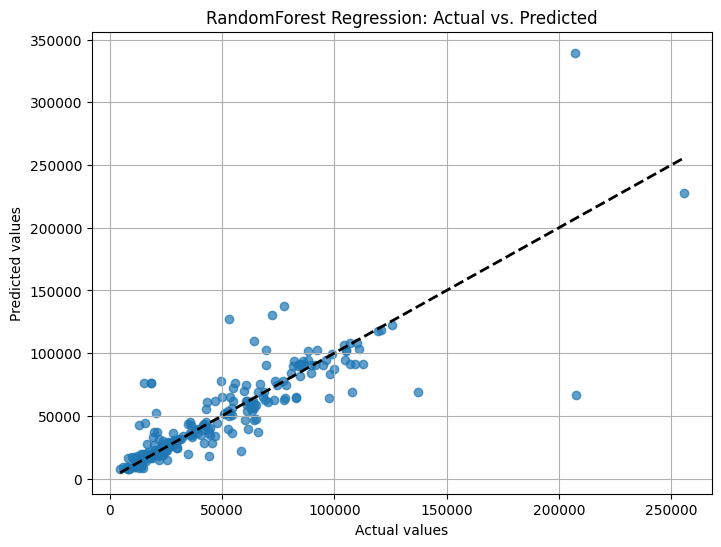

In [29]:
# Visualize predictions vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.title('RandomForest Regression: Actual vs. Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal line for reference
plt.grid(True)
plt.show()

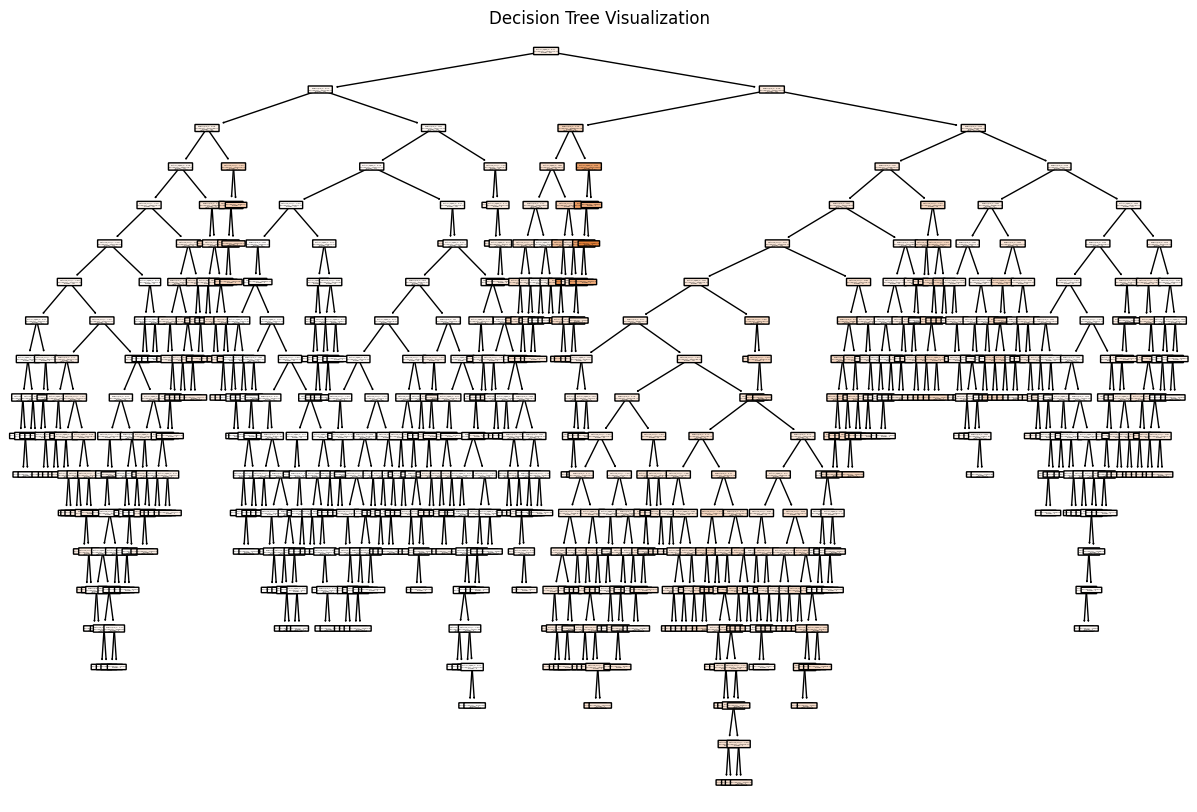

In [32]:
from sklearn.tree import plot_tree

# Fit the DecisionTreeRegressor model
best_estimator_dt.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(15, 10))
plot_tree(best_estimator_dt.named_steps['dt'], filled=True, feature_names=features, rounded=True)
plt.title('Decision Tree Visualization')
plt.show()


Feature Importances for Decision Tree:
              Feature  Importance
1       Rainfall (mm)    0.536539
2  Fertilizer (kg/ha)    0.317716
0   Pesticides (Tons)    0.145745


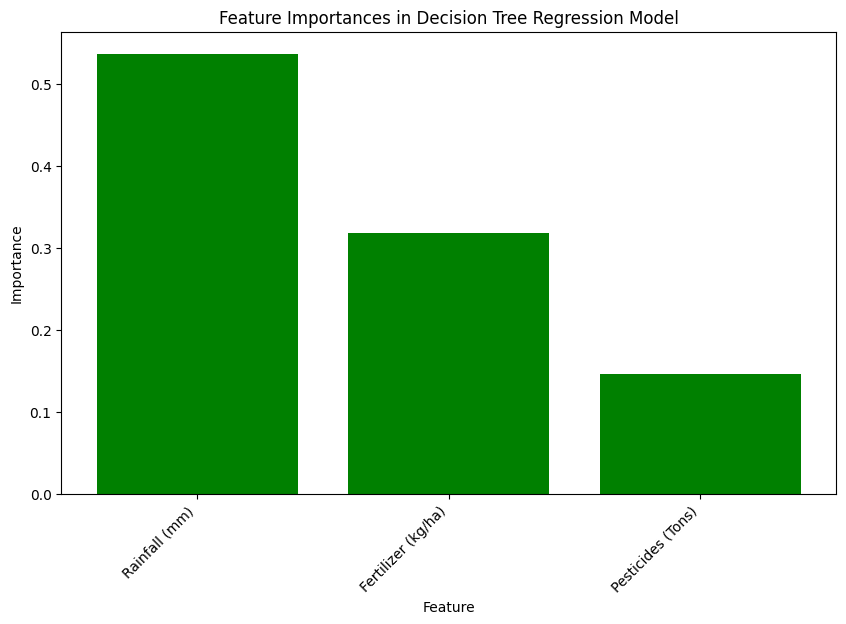

In [31]:
# Get feature importances from the trained DecisionTreeRegressor model
feature_importances_dt = best_estimator_dt.named_steps['dt'].feature_importances_

# Create a DataFrame to store feature names and their importance scores for Decision Tree
feature_importance_df_dt = pd.DataFrame({'Feature': features, 'Importance': feature_importances_dt})

# Sort features by importance in descending order
feature_importance_df_dt = feature_importance_df_dt.sort_values(by='Importance', ascending=False)

# Print and plot feature importances for Decision Tree
print("\nFeature Importances for Decision Tree:")
print(feature_importance_df_dt)

# Plotting the feature importances for Decision Tree
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df_dt['Feature'], feature_importance_df_dt['Importance'], color='green')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances in Decision Tree Regression Model')
plt.xticks(rotation=45, ha='right')
plt.show()